In [1]:
import json
import os
import pandas as pd
import pysam
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("/home1/smaruj/akitaX1-analyses/figures/plot_styles/global_plotting_style.mplstyle")
import tensorflow as tf
from basenji import seqnn, stream

from akita_utils.dna_utils import dna_1hot
from akita_utils.numpy_utils import ut_dense
from akita_utils.seq_gens import (
    symmertic_insertion_seqs_gen,
    reference_seqs_gen,
)
from akita_utils.tsv_utils import (
    add_orientation,
    add_background,
    add_diff_flanks_and_const_spacer,
)

2024-07-25 14:32:34.399166: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-25 14:32:34.399214: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-25 14:32:34.400788: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-25 14:32:34.410349: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-25 14:32:35.335765: W tensorflow/comp

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = '-1' ### run on CPU
print(tf.config.list_physical_devices('GPU'))

[]


In [3]:
# arguments 
genome_fasta = "/project/fudenber_735/genomes/mm10/mm10.fa" 
stats = "SCD,INS-16,INS-64"
batch_size=8
head_index = 1
model_index = 1
shifts = "0"
rc = False
background_file = f"/project/fudenber_735/akitaX1_analyses_data/background_generation/background_generation/background_sequences_model_{model_index}.fa"
shifts = [int(shift) for shift in shifts.split(",")]
stats = stats.split(",")

# top 10 strongest CTCF sites
CTCT_table = "./top10_insSCD.tsv"

models_dir="/project/fudenber_735/tensorflow_models/akita/v2/models"
params_file = models_dir + f"/f{model_index}c0" + "/train" + "/params.json"
model_file = models_dir + f"/f{model_index}c0" + "/train" + f"/model{head_index}_best.h5"
print("params_file: ", params_file)
print("model_file: ", model_file)

params_file:  /project/fudenber_735/tensorflow_models/akita/v2/models/f1c0/train/params.json
model_file:  /project/fudenber_735/tensorflow_models/akita/v2/models/f1c0/train/model1_best.h5


### Loading the model

In [4]:
# read model parameters
with open(params_file) as params_open:
    params = json.load(params_open)
params_train = params["train"]
params_model = params["model"]

if batch_size is None:
    batch_size = params_train["batch_size"]
else:
    batch_size = batch_size

# load model
seqnn_model = seqnn.SeqNN(params_model)
seqnn_model.restore(model_file, head_i=head_index)
seqnn_model.build_ensemble(rc, shifts)
seq_length = int(params_model["seq_length"])

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 sequence (InputLayer)       [(None, 1310720, 4)]         0         []                            
                                                                                                  
 stochastic_reverse_complem  ((None, 1310720, 4),         0         ['sequence[0][0]']            
 ent (StochasticReverseComp   ())                                                                 
 lement)                                                                                          
                                                                                                  
 stochastic_shift (Stochast  (None, 1310720, 4)           0         ['stochastic_reverse_complemen
 icShift)                                                           t[0][0]']               

### Preparing table with insertion parameters

In [5]:
# open genome FASTA
genome_open = pysam.Fastafile(genome_fasta)

In [6]:
seq_coords_df = pd.read_csv(CTCT_table, sep="\t")
seq_coords_df = seq_coords_df[["chrom", "end", "start", "strand"]]

num_sites = 3
seq_coords_df = seq_coords_df[:num_sites].reset_index(drop=True)
seq_coords_df["seq_index"] = [i for i in range(num_sites)]

# insertion parameters
flanks = [0, 5, 10, 20]
orient_list = [">>", "<<", "><", "<>"]
background_indices_list = [x for x in range(10)]
flank_spacer_sum = 90

rep_unit = seq_coords_df

for i in range(len(flanks)-1):
    seq_coords_df = pd.concat(
                    [seq_coords_df, rep_unit], ignore_index=True
                )
seq_coords_df = seq_coords_df.sort_values(by="seq_index").reset_index(drop=True)
seq_coords_df["flank_bp"] = flanks + flanks + flanks

# adding orientation
seq_coords_df = add_orientation(
    seq_coords_df,
    orientation_strings=orient_list,
    all_permutations=False,
)

# adding background index
seq_coords_df = add_background(
    seq_coords_df, 
    background_indices_list
    )

seq_coords_df["spacer_bp"] = flank_spacer_sum - seq_coords_df["flank_bp"]

### Reading background sequences and predicting maps for them

In [7]:
background_seqs = []
    
with open(background_file, "r") as f:
    for line in f.readlines():
        if ">" in line:
            continue
        background_seqs.append(dna_1hot(line.strip()))

# num_insert_backgrounds = seq_coords_df["background_index"].max()
num_insert_backgrounds = 1

if len(background_seqs) < num_insert_backgrounds:
    raise ValueError(
        "must provide a background file with at least as many"
        + "backgrounds as those specified in the insert seq_coords tsv."
        + "\nThe provided background file has {len(background_seqs)} sequences."
    )

In [8]:
backgrounds_predictions = seqnn_model.predict(np.array(background_seqs), batch_size=batch_size)

2/2 [==============================] - 25s 5s/step


### Averaging data and plotting maps

In [9]:
preds_stream = stream.PredStreamGen(
        seqnn_model,
        symmertic_insertion_seqs_gen(seq_coords_df, background_seqs, genome_open),
        batch_size,
    )

In [10]:
num_experiments = len(seq_coords_df)

In [11]:
summary_matrix = np.zeros((3, 4, 4, 10, 6, 130305))
# num_sequences, num_orientations, num_flanks, num_backgrounds, num_targets, pred_vector_len

In [12]:
for exp_index in range(num_experiments):
    
    print(f"experiment {exp_index}")

    seq_index = seq_coords_df.iloc[exp_index].seq_index
    orient = seq_coords_df.iloc[exp_index].orientation
    flank_bp = seq_coords_df.iloc[exp_index].flank_bp
    bg_index = seq_coords_df.iloc[exp_index].background_index

    # assigning indices to flanks and orientations
    if flank_bp == 0:
        flank_index = 0
    elif flank_bp == 5:
        flank_index = 1
    elif flank_bp == 10:
        flank_index = 2
    elif flank_bp == 20:
        flank_index = 3
    
    if orient == ">>":
        orient_index = 0
    if orient == "<<":
        orient_index = 1    
    if orient == "><":
        orient_index = 2
    elif orient == "<>":
        orient_index = 3
    
    prediction_matrix = preds_stream[exp_index]
    reference_prediction_matrix = backgrounds_predictions[bg_index, :, :]

    difference_matrix = prediction_matrix - reference_prediction_matrix

    for target_index in range(6):
        summary_matrix[seq_index, orient_index, flank_index, bg_index, target_index, ] += difference_matrix[:,target_index]
            

experiment 0
4/4 [==============================] - 75s 19s/step
experiment 1
experiment 2
experiment 3
experiment 4
experiment 5
experiment 6
experiment 7
experiment 8
experiment 9
experiment 10
experiment 11
experiment 12
experiment 13
experiment 14
experiment 15
experiment 16
experiment 17
experiment 18
experiment 19
experiment 20
experiment 21
experiment 22
experiment 23
experiment 24
experiment 25
experiment 26
experiment 27
experiment 28
experiment 29
experiment 30
experiment 31
experiment 32
4/4 [==============================] - 74s 19s/step
experiment 33
experiment 34
experiment 35
experiment 36
experiment 37
experiment 38
experiment 39
experiment 40
experiment 41
experiment 42
experiment 43
experiment 44
experiment 45
experiment 46
experiment 47
experiment 48
experiment 49
experiment 50
experiment 51
experiment 52
experiment 53
experiment 54
experiment 55
experiment 56
experiment 57
experiment 58
experiment 59
experiment 60
experiment 61
experiment 62
experiment 63
experiment

In [13]:
# averaging over backgrounds and targets
ave_summary_matrix = summary_matrix.mean(axis=(3,4))

In [14]:
orientation_set = ['>>', '<<', '><', '<>']

In [15]:
# picking one sequence
seq_index = 2

plotting: flank=0
plotting: flank=0
plotting: flank=0
plotting: flank=0
plotting: flank=5
plotting: flank=5
plotting: flank=5
plotting: flank=5
plotting: flank=10
plotting: flank=10
plotting: flank=10
plotting: flank=10
plotting: flank=20
plotting: flank=20
plotting: flank=20
plotting: flank=20
chr7_37357852-37357871


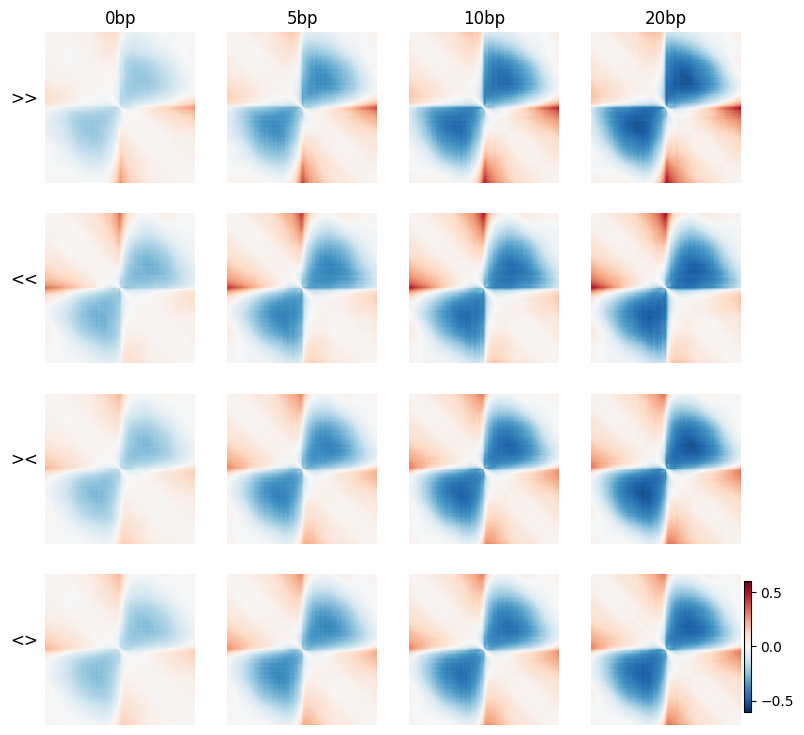

In [17]:
rows = [orientation for orientation in orientation_set]
cols = [str(flank)+"bp" for flank in flanks]

fig, axs = plt.subplots(len(orientation_set), len(flanks), figsize=(9,9))

for flank_idx in range(len(flanks)):
    for orient_idx in range(len(orientation_set)):
        print(f"plotting: flank={flanks[flank_idx]}")
        
        plot_matrix = ut_dense(np.expand_dims(ave_summary_matrix[seq_index, orient_idx, flank_idx, :], 1), diagonal_offset=2)
        plot_matrix = np.squeeze(plot_matrix, axis=2)
        vmin = -0.6
        vmax = 0.6
        
        sns.heatmap(
            plot_matrix,
            ax=axs[orient_idx, flank_idx],
            center=0,
            vmin=vmin,
            vmax=vmax,
            cbar=False,
            cmap="RdBu_r",
            square=True,
            xticklabels=False,
            yticklabels=False,
        )
        
for ax, col in zip(axs[0], cols):
    ax.set_title(col, size=12)

for ax, row in zip(axs[:,0], rows):
    ax.set_ylabel(row, rotation=0, fontsize=12, labelpad=15)

a = np.array([[-0.6,0.6]])
img = plt.imshow(a, cmap="RdBu_r")

cb_ax = fig.add_axes([0.902, 0.125, 0.008, 0.145])
cbar = fig.colorbar(img,orientation='vertical',cax=cb_ax)
for t in cbar.ax.get_yticklabels():
     t.set_fontsize(10)

coordinates_string = seq_coords_df.iloc[seq_index].chrom + "_" + str(seq_coords_df.iloc[seq_index].start) + "-" + str(seq_coords_df.iloc[seq_index].end)
print(coordinates_string)
# plt.show()
# plt.savefig(f"./plots/double_insertion_{coordinates_string}.pdf", format="pdf", bbox_inches="tight")
# plt.savefig(f"./plots/double_insertion_{coordinates_string}.png", format="png", bbox_inches="tight")

In [18]:
genome_open.close()